<a href="https://colab.research.google.com/github/ayulockin/DataAugmentationTF/blob/master/CIFAR_10_with_Mixup_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [1]:
!nvidia-smi

Tue Jun 16 18:58:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [25]:
!git clone https://github.com/ayulockin/DataAugmentationTF

Cloning into 'DataAugmentationTF'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 18), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [26]:
%cd DataAugmentationTF/

/content/DataAugmentationTF


In [27]:
!ls

augment_and_mix.py
augmentations.py
CIFAR_10_Baseline_Model.ipynb
Cifar_10_Evaluation_Robustness_to_Cifar_10C.ipynb
CIFAR_10_with_AugMix_Augmentation.ipynb
CIFAR_10_with_CutMix_Augmentation.ipynb
CIFAR_10_with_Cutout_Augmentation.ipynb
CIFAR_10_with_Mixup_Augmentation.ipynb
images
models
README.md


In [0]:
%%capture
!pip install wandb

In [0]:
SEED = 666

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import resnet50

import tensorflow_addons as tfa

In [0]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [0]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [9]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


# Download and Prepare Dataset

#### CIFAR-10

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = pd.get_dummies(y_train.flatten()).values.astype(np.float32)
y_test = pd.get_dummies(y_test.flatten()).values.astype(np.float32)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [14]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


# Visualize

In [0]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[np.argmax(label_batch[n])])
      plt.axis('off')

#### Train Set

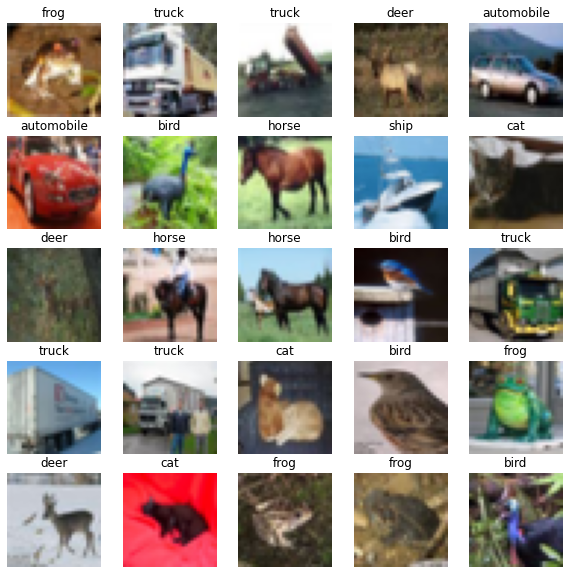

In [15]:
image_batch, label_batch = x_train[:32], y_train[:32]
show_batch(image_batch, label_batch)

#### Test Set

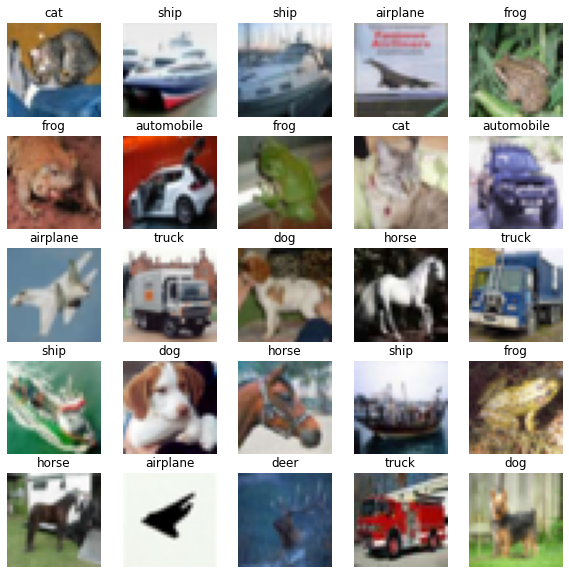

In [16]:
image_batch, label_batch = x_test[:32], y_test[:32]
show_batch(image_batch, label_batch)

# Model

In [0]:
from models.resnet import resnet_v1

In [0]:
def Model():
  return resnet_v1((32,32,3), 20) ## Returns a ResNet20 model.

# Callbacks

In [0]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True ## This will ensure the best instance of the model over the validation set.
)

# Train with Mixup Augmentation

#### Mixup Dataloader

In [0]:
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = image/255.
  return image, label

In [0]:
# For Beta distribution.
alpha = [0.2]
beta = [0.2]

def mixup(a, b):
  
  (image1, label1), (image2, label2) = a, b

  dist = tfd.Beta(alpha, beta)
  l = dist.sample(1)[0][0]
  
  img = l*image1+(1-l)*image2
  lab = l*label1+(1-l)*label2

  return img, lab

In [0]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32


trainloader1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
trainloader2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)

trainloader = tf.data.Dataset.zip((trainloader1, trainloader2))
trainloader = (
    trainloader
    .shuffle(1024)
    .map(mixup, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

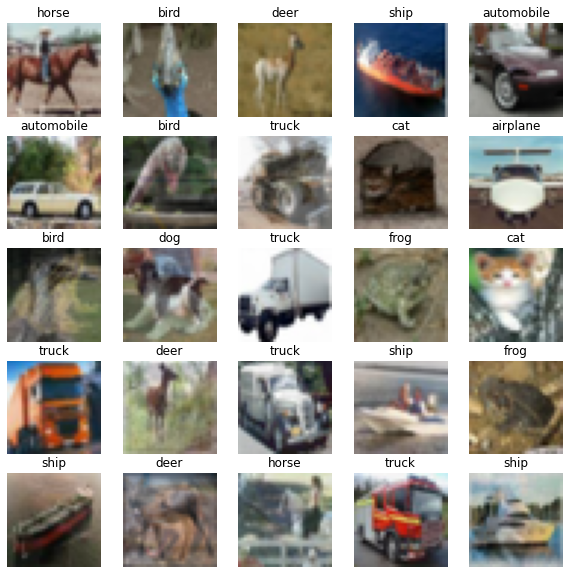

In [19]:
image_batch, label_batch = next(iter(trainloader))
image_batch.shape, label_batch.shape

show_batch(image_batch, label_batch)

#### Initialize Model

In [31]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Compile

In [0]:
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

#### Wandb Init

In [33]:
wandb.init(entity='authors', project='tfaugmentation')

W&B Run: https://app.wandb.ai/authors/tfaugmentation/runs/3osrp98g

#### Train

In [34]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.6525 - acc: 0.5140 - val_loss: 1.7207 - val_acc: 0.4851
Epoch 2/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3325 - acc: 0.6564 - val_loss: 1.4300 - val_acc: 0.5625
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2067 - acc: 0.7142 - val_loss: 1.0525 - val_acc: 0.6964
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1422 - acc: 0.7419 - val_loss: 1.6591 - val_acc: 0.5070
Epoch 5/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0883 - acc: 0.7674 - val_loss: 1.0802 - val_acc: 0.6884
Epoch 6/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0492 - acc: 0.7859 - val_loss: 0.8968 - val_acc: 0.7530
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0226 - acc: 0.7980 - val_loss: 0.9446 - val_acc: 0.7416
Epoch 8/100
1563/1563 [==================

#### Save your hardwork

In [35]:
%cd ../../

/


In [0]:
model.save('gdrive/My Drive/DataAugmentation/mixup.h5')

## Evaluate

#### Evaluate on CIFAR-10

In [38]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100,2))

313/313 [==============================] - 2s 5ms/step - loss: 0.7548 - acc: 0.8221
Test Error Rate:  17.79


# Ablation Study

> The aim of this study is to look at the dependence of alpha value to the test error rate. 

In [0]:
def prepare_dataloader(alpha, beta):

  def mixup(a, b):
    (image1, label1), (image2, label2) = a, b

    dist = tfd.Beta(alpha, beta)
    l = dist.sample(1)[0]
    
    img = l*image1+(1-l)*image2
    lab = l*label1+(1-l)*label2

    return img, lab

  trainloader1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
  trainloader2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)

  trainloader = tf.data.Dataset.zip((trainloader1, trainloader2))
  trainloader = (
      trainloader
      .shuffle(1024)
      .map(mixup, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )

  testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  testloader = (
      testloader
      .map(preprocess_image, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
  )

  return trainloader, testloader

In [0]:
ALPHAS = [0.1, 0.2, 0.4, 0.7, 0.9, 1.0]

In [0]:
keras.backend.clear_session()
model = Model()

model.save('initial_wt.h5')

In [63]:
for idx, alpha in enumerate(ALPHAS):
  print('[INFO] Using alpha: ', alpha)
  ## Get cutout data loader with cutsize
  trainloader, testloader = prepare_dataloader(alpha, alpha)
  ## Initalize model
  keras.backend.clear_session()
  model = Model()
  model.load_weights('initial_wt.h5')
  ## Compile model
  model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
  ## Wandb init
  wandb.init(entity='authors', project='tfaugmentation')
  _ = model.fit(trainloader,
          epochs=100,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     earlystoper])
  ## save model
  model.save('model_mixup_{}.h5'.format(idx))
  model.save('gdrive/My Drive/DataAugmentation/model_mixup_{}.h5'.format(idx))

[INFO] Using alpha:  0.1


Epoch 1/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6156 - acc: 0.5057 - val_loss: 1.6379 - val_acc: 0.4670
Epoch 2/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2713 - acc: 0.6499 - val_loss: 1.1584 - val_acc: 0.6530
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1221 - acc: 0.7160 - val_loss: 1.2616 - val_acc: 0.6306
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0378 - acc: 0.7519 - val_loss: 0.9376 - val_acc: 0.7393
Epoch 5/100
1563/1563 [==============================] - 27s 18ms/step - loss: 0.9742 - acc: 0.7811 - val_loss: 1.1474 - val_acc: 0.6743
Epoch 6/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9239 - acc: 0.8005 - val_loss: 0.9316 - val_acc: 0.7450
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8901 - acc: 0.8181 - val_loss: 0.8882 - val_acc: 0.7614
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.6915 - acc: 0.4959 - val_loss: 1.7314 - val_acc: 0.4391
Epoch 2/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3695 - acc: 0.6405 - val_loss: 1.2652 - val_acc: 0.6281
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2485 - acc: 0.6960 - val_loss: 1.4299 - val_acc: 0.5805
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1681 - acc: 0.7350 - val_loss: 1.2192 - val_acc: 0.6482
Epoch 5/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1162 - acc: 0.7555 - val_loss: 1.0663 - val_acc: 0.7067
Epoch 6/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0700 - acc: 0.7782 - val_loss: 0.8894 - val_acc: 0.7586
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0422 - acc: 0.7905 - val_loss: 1.0516 - val_acc: 0.6998
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.7907 - acc: 0.4780 - val_loss: 1.5101 - val_acc: 0.5087
Epoch 2/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5084 - acc: 0.6169 - val_loss: 1.3570 - val_acc: 0.5812
Epoch 3/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3788 - acc: 0.6796 - val_loss: 1.3250 - val_acc: 0.6081
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3190 - acc: 0.7112 - val_loss: 1.1508 - val_acc: 0.6649
Epoch 5/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2775 - acc: 0.7284 - val_loss: 1.1412 - val_acc: 0.6705
Epoch 6/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2400 - acc: 0.7492 - val_loss: 1.1879 - val_acc: 0.6371
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2134 - acc: 0.7600 - val_loss: 0.9689 - val_acc: 0.7352
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.8791 - acc: 0.4571 - val_loss: 1.7678 - val_acc: 0.4406
Epoch 2/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6261 - acc: 0.5894 - val_loss: 1.1944 - val_acc: 0.6470
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5157 - acc: 0.6432 - val_loss: 1.0617 - val_acc: 0.7035
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4561 - acc: 0.6707 - val_loss: 1.0595 - val_acc: 0.6970
Epoch 5/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4131 - acc: 0.6988 - val_loss: 1.3329 - val_acc: 0.6035
Epoch 6/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3822 - acc: 0.7131 - val_loss: 0.9852 - val_acc: 0.7367
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3563 - acc: 0.7293 - val_loss: 0.8687 - val_acc: 0.7644
Epoch 8/100
1563/1563 [==================

Epoch 1/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.9160 - acc: 0.4475 - val_loss: 1.5146 - val_acc: 0.5396
Epoch 2/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.6849 - acc: 0.5722 - val_loss: 1.2048 - val_acc: 0.6384
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5770 - acc: 0.6255 - val_loss: 1.4164 - val_acc: 0.5654
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5158 - acc: 0.6571 - val_loss: 1.4124 - val_acc: 0.5636
Epoch 5/100
1563/1563 [==============================] - 29s 19ms/step - loss: 1.4700 - acc: 0.6820 - val_loss: 1.1272 - val_acc: 0.6718
Epoch 6/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4397 - acc: 0.6978 - val_loss: 1.0464 - val_acc: 0.6990
Epoch 7/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4169 - acc: 0.7092 - val_loss: 0.9777 - val_acc: 0.7158
Epoch 8/100
1523/1563 [==================

In [27]:
ablation_dict = {}

for file in os.listdir('/gdrive/My Drive/DataAugmentation/'):
  if file.endswith('.h5') and 'model_mixup' in file:
    model = keras.models.load_model('/gdrive/My Drive/DataAugmentation/'+file)
    loss, acc = model.evaluate(testloader, verbose=0)
    print(file, (1-acc)*100)
    ablation_dict[int(file.split('.')[0].split('_')[-1])] = round((acc)*100, 2)

model_mixup_0.h5 22.200000286102295
model_mixup_1.h5 20.410001277923584
model_mixup_2.h5 17.589998245239258
model_mixup_3.h5 18.50000023841858
model_mixup_4.h5 18.01999807357788
model_mixup_5.h5 16.920000314712524


In [28]:
ablation_dict

{0: 77.8, 1: 79.59, 2: 82.41, 3: 81.5, 4: 81.98, 5: 83.08}

In [0]:
alpha, test_acc = zip(*sorted(zip(list(ablation_dict.keys()), list(ablation_dict.values()))))

In [42]:
wandb.init(entity='authors', project='tfaugmentation')

for k, v in zip(alpha, test_acc):
  wandb.log({'alpha': k, 'test accuracy %': v})

In [44]:
plt.figure(figsize=(8,8))
plt.plot(alpha, test_acc)
plt.title('alpha vs test accuracy')
plt.xlabel('alpha (encoded)')
plt.ylabel('Test Accuracy in %')
plt.grid(True)

wandb.log({'alpha vs test acc': plt})
plt.close()

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

